In [36]:
## MGH10
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from scipy.misc import derivative
import time

In [37]:
data= pd.read_csv("MGH09_Data.txt",names=['y','x'], sep=" ")

data

,y,x
NaN,0.1957,4.0000
NaN,0.1947,2.0000
NaN,0.1735,1.0000
NaN,0.1600,0.5000
NaN,0.0844,0.2500
NaN,0.0627,0.1670
NaN,0.0456,0.1250
NaN,0.0342,0.1000
NaN,0.0323,0.0833
NaN,0.0235,0.0714


In [38]:
y = torch.from_numpy(data['y'].to_numpy(np.float64))
x = torch.from_numpy(data['x'].to_numpy(np.float64))

# b = torch.tensor([25.0,39.0,41.5,39.0],requires_grad=True)
b = torch.tensor([0.25,0.39,0.415,0.39],requires_grad=True)
# b = torch.tensor([2.0,400000.0,25000.0],requires_grad=True)

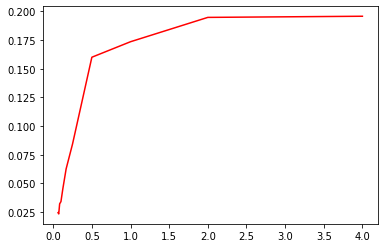

In [39]:
plt.plot(x.numpy(),y.numpy(),"r")

In [40]:
## Numerical Differentiation
b = np.array([0.25,0.39,0.415,0.39]).reshape(-1,1)

x=x.detach().numpy()

u=0.1 #beta multiply identity matrix
beta = 10
V_prev = 0


def f0(b0):
    return  b0*(np.power(x,2)+x*b[1]) / (np.power(x,2)+x*b[2]+b[3]) -y.detach().numpy()  
def f1(b1):
    return b[0]*(np.power(x,2)+x*b1) / (np.power(x,2)+x*b[2]+b[3])-y.detach().numpy()  
def f2(b2):
    return  b[0]*(np.power(x,2)+x*b[1]) / (np.power(x,2)+x*b2+b[3]) -y.detach().numpy()  
def f3(b3):
    return  b[0]*(np.power(x,2)+x*b[1]) / (np.power(x,2)+x*b[2]+b3) -y.detach().numpy()  


start_time = time.perf_counter()
for c in range(500):
    
    y_pred = b[0]*(np.power(x,2)+x*b[1]) / (np.power(x,2)+x*b[2]+b[3])
    error = (y_pred - y.detach().numpy()).reshape(-1,1)
    
    d_b0 = derivative(f0,b[0] , dx=1e-6)
    d_b1 = derivative(f1,b[1] , dx=1e-6)
    d_b2 = derivative(f2,b[2] , dx=1e-6)
    d_b3 = derivative(f3,b[3] , dx=1e-6)
        
    jacobian = np.transpose(np.array([d_b0,d_b1,d_b2,d_b3]))
    dParam = np.matmul(np.matmul(np.linalg.inv((np.matmul(np.transpose(jacobian),jacobian)+u*np.identity(len(b)))),np.transpose(jacobian)),error)
    b -= dParam
    V = np.sum(np.square(error))
    if(V > V_prev):
            u *= beta
    else:
            u /= beta
    V_prev = V
    print("c: ",c," error: ",V," B:", b)
    if V < 3.0750560385E-04:
        break
print("time taken to execute: ",time.perf_counter()-start_time) 
print("SD error is", np.std(np.square(loss.detach().numpy())))

c:  0  error:  0.00531317227210854  B: [[0.21222478]
 [0.4412573 ]
 [0.40724696]
 [0.32022756]]
c:  1  error:  0.0015528591934103613  B: [[0.21191188]
 [0.44597402]
 [0.40596371]
 [0.31252827]]
c:  2  error:  0.001370860501592735  B: [[0.2037138 ]
 [0.46965255]
 [0.3977129 ]
 [0.2725985 ]]
c:  3  error:  0.0006803535784074159  B: [[0.19356387]
 [0.49042288]
 [0.35145417]
 [0.24741685]]
c:  4  error:  0.000444695965470373  B: [[0.18686704]
 [0.44716953]
 [0.23084769]
 [0.23991405]]
c:  5  error:  0.0003640186990971609  B: [[0.19572811]
 [0.07485963]
 [0.08334033]
 [0.09348391]]
c:  6  error:  0.0004756372603633312  B: [[0.1911741 ]
 [0.19266935]
 [0.10311206]
 [0.14534352]]
c:  7  error:  0.0003302434795492949  B: [[0.19315763]
 [0.18209823]
 [0.12122759]
 [0.1314799 ]]
c:  8  error:  0.0003077469507968045  B: [[0.1925449 ]
 [0.19702819]
 [0.12410215]
 [0.13873609]]
c:  9  error:  0.0003075677286912121  B: [[0.19297032]
 [0.18754881]
 [0.12233309]
 [0.13434463]]
c:  10  error:  0.000307

In [41]:
def Jacobian(loss,params,numParams):
    
    jacobian = torch.empty(len(loss), numParams) 
    
    for i in range(len(loss)):
        
        loss[i].backward(retain_graph=True)
        
        for n in range(numParams):
            jacobian[i][n] = params.grad[n]
        params.grad.zero_()      
    return jacobian    

In [42]:
## Automatic Differentiation
num_param = len(b)
u=0.1 #beta multiply identity matrix
beta = 10
error_prev = 0
start_time = time.perf_counter()
for c in range(500):
    
    y_pred = b[0]*(torch.pow(x,2)+x*b[1]) / (torch.pow(x,2)+x*b[2]+b[3])
    
    loss = y_pred-y
    error = torch.sum(torch.square(loss)) #residual sum of squares
    print("",c," error is: ",error.detach().numpy()," b is ", b.detach().numpy())
    jacobian = Jacobian(loss,b,len(b))

    dParam = torch.matmul(torch.matmul(torch.inverse(torch.matmul(torch.transpose(jacobian,-1,0),jacobian)+u*torch.eye(num_param, num_param)),torch.transpose(jacobian,-1,0)),loss.float())
    with torch.no_grad():
        b -=dParam
    
        if(error > error_prev):
            u *= beta
        else:
            u /= beta
        error_prev = error
    if error<  3.0750560385E-04: # given residual sum of squares
        break
print("time taken to execute: ",time.perf_counter()-start_time) 
print("SD error is", np.std(np.square(loss.detach().numpy())))

TypeError: pow() received an invalid combination of arguments - got (numpy.ndarray, int), but expected one of:
 * (Tensor input, Tensor exponent, *, Tensor out)
 * (Number self, Tensor exponent, *, Tensor out)
 * (Tensor input, Number exponent, *, Tensor out)


In [ ]:
plt.plot(y_pred.detach(),'g', y,'r.')

In [ ]:
y_pred = b[0] / (torch.pow(1+torch.exp(b[1]-b[2]*x),(1/b[3])))

